## BOS - TMDS Vital Signs Analysis

### Ler os arquivos de log

Análise é feita em todos os arquivos <b>*.txt</b> que estão dentro da pasta <b>logs</b>.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import glob
import seaborn as sns
import warnings

In [2]:
#%%time
# salva o caminho de todos os arquivos BackOfficeServer*.txt da pasta logs
all_files_path = glob.glob("logs/BackOfficeServer*.txt")
# palavras-chave para buscar nas linhas do arquivo
key_words = [['TMDS VITAL SIGNS'],['Top']]
tmds_vital_signs_list = []
memory_used_status_list = []
# ler abre e ler as linhas do arquivo a partir das key_words
for file_path in  all_files_path:
    file = open(file_path,'r')
    lines = file.readlines()
    # encontra a palavra chave 'TMDS VITAL SIGNS' e retorna as 10 linhas seguintes em uma lista
    tmds_vital_signs_list += [lines[index:index+11] for index, line in enumerate(lines) if any(word in line for word in key_words[0])] 
    # encontra a palavra chave 'Percent memory used is' e retorna as 2 linhas seguintes em uma lista
    memory_used_status_list += [lines[index-1:index+2] for index, line in enumerate(lines) if any(word in line for word in key_words[1])]
    # fecha conexão com o arquivo
    file.close()
print("Total de arquivos lidos:", len(all_files_path))
print("Total de eventos capturados (TMDs Vital Signs) :", len(tmds_vital_signs_list))
print("Total de eventos capturados (Memory Used Status) :", len(memory_used_status_list))

Total de arquivos lidos: 4
Total de eventos capturados (TMDs Vital Signs) : 2712
Total de eventos capturados (Memory Used Status) : 2712


### Pré-processamento dos dados de texto
Preparando o texto descartando as partes menos úteis: converter texto para lowercase, remoção de palavras irrelevantes e backslash notation.

In [3]:
# remove os characters ('\t' e '\n') das extremidades das linhas e quebra a linha em duas partes
# salva as linhas como uma lista de dicionários
tmds_vital_signs_list_refined = [ {line[1:-1].split(':',1)[0]:line[1:-1].split(':',1)[1].strip()} for tmds_vital_signs in tmds_vital_signs_list for line in tmds_vital_signs[1:-3] ]

In [4]:
# agrupa a sequência de pares de key-value em um dicionário de listas 
tmds_vital_signs_dict = {}
for dict in tmds_vital_signs_list_refined:
    k = list(dict.keys())[0].lower()
    v = list(dict.values())[0].lower()
    tmds_vital_signs_dict.setdefault(k, []).append(v)

In [5]:
# salva datetime da primeira linha da lista tmds_vital_signs_list e converte milisegundos para microsegundos
event_datetime_list = [ tmds_vital_signs[0].split('     ',1)[0] + '000' for tmds_vital_signs in tmds_vital_signs_list ]

In [6]:
# salva memory used e memory available da lista memory_used_status_list
percent_memory_used_list = [ memory_used_status[0].split(" ")[-7] for memory_used_status in memory_used_status_list ]
memory_available_list = [ memory_used_status[0].split(" ")[-4] for memory_used_status in memory_used_status_list ]
# salva contagem de number of trains, activated trains e cutout trains a partir da última linha da lista memory_used_status_list
count_trains_line_split_list = [ memory_used_status[-1].split('=') for memory_used_status in memory_used_status_list ]
num_of_trains_list=[]
activated_trains_list=[]
cutout_trains_list=[]
for words in count_trains_line_split_list:
    num_of_trains_list.append(words[1].split()[0])
    activated_trains_list.append(words[2].split(':')[0])
    cutout_trains_list.append(words[3].split(')')[0])

### DataFrame

Cria o DataFrame e adiciona colunas

In [7]:
# criar o data frame a partir do dicionário tmds_vital_signs_dict
df = pd.DataFrame(tmds_vital_signs_dict)
# adiciona as colunas ao DataFrame
df['event datetime'] = event_datetime_list
df['num of trains'] = num_of_trains_list
df['activated trains'] = activated_trains_list
df['cutout trains'] = cutout_trains_list
df['memory used'] = percent_memory_used_list
df['memory available'] = memory_available_list

Trata os dados incorretos e converte os tipos das colunas para numéricos

In [8]:
# verifica se contem '%' e converte a coluna 'memory used' de object para float se não retorna NaN
df['memory used'] = df['memory used'].apply(lambda x: float(x[:-1]) if x[-1]=='%' else np.nan)
# verifica se tamanho é correto e converte a coluna 'memory available' de object para float se não retorna NaN
df['memory available'] = df['memory available'].apply(lambda x: int(x) if len(x)==11 else np.nan)
# converte a coluna 'event datime' de object para datetime
df['event datetime'] = df['event datetime'].apply(lambda x: pd.to_datetime(x))
# ordena data frame beaseado na coluna 'event datetime' 
df = df.sort_values('event datetime')
# converte a coluna 'start time' de object para datetime
df['start time'] = df['start time'].apply(lambda x: pd.to_datetime(x))
# converte as colunas de object para int
df[['handle count','thread count','num of trains','activated trains','cutout trains']] = df[['handle count','thread count','num of trains','activated trains','cutout trains']].astype(int)
# converte as colunas de object para int
df[['paged memory','paged peak memory','working memory','working peak memory']] = df[['paged memory','paged peak memory','working memory','working peak memory']].astype(int)

Os Valores faltantes serão preenchidos com a média de suas respectivas colunas

In [9]:
count_missing_values = df['memory used'].isnull().sum()
count_missing_values_2 = df['memory available'].isnull().sum()
print('Valores faltantes para Memory Used:', count_missing_values)
print('Valores faltantes para Memory Available:', count_missing_values_2)

Valores faltantes para Memory Used: 4
Valores faltantes para Memory Available: 4


In [10]:
# prenche os valores faltantes com a média de suas rescpetivos colunas
df.fillna(df.mean(), inplace=True)
# usa a coluna 'event datetime como index'
df = df.set_index('event datetime')
# top 5 linhas do data frame
df.head()

,start time,working memory,paged memory,working peak memory,paged peak memory,thread count,handle count,num of trains,activated trains,cutout trains,memory used,memory available
event datetime,,,,,,,,,,,,
2018-05-25 00:00:30.624,2018-05-09 20:23:04,1037549568,1070718976,1242947584,1363333120,108,1262,157,43,96,13.41,1.487480e+10
2018-05-25 00:01:00.030,2018-05-09 20:23:04,1056808960,1089003520,1242947584,1363333120,108,1262,155,44,94,13.48,1.486390e+10
2018-05-25 00:01:30.450,2018-05-09 20:23:04,1078800384,1110953984,1242947584,1363333120,107,1255,155,44,93,13.64,1.483693e+10
2018-05-25 00:02:00.870,2018-05-09 20:23:04,1099628544,1131683840,1242947584,1363333120,108,1270,156,43,94,14.01,1.477186e+10
2018-05-25 00:02:30.276,2018-05-09 20:23:04,1132548096,1166766080,1242947584,1363333120,108,1264,156,44,94,14.05,1.476576e+10


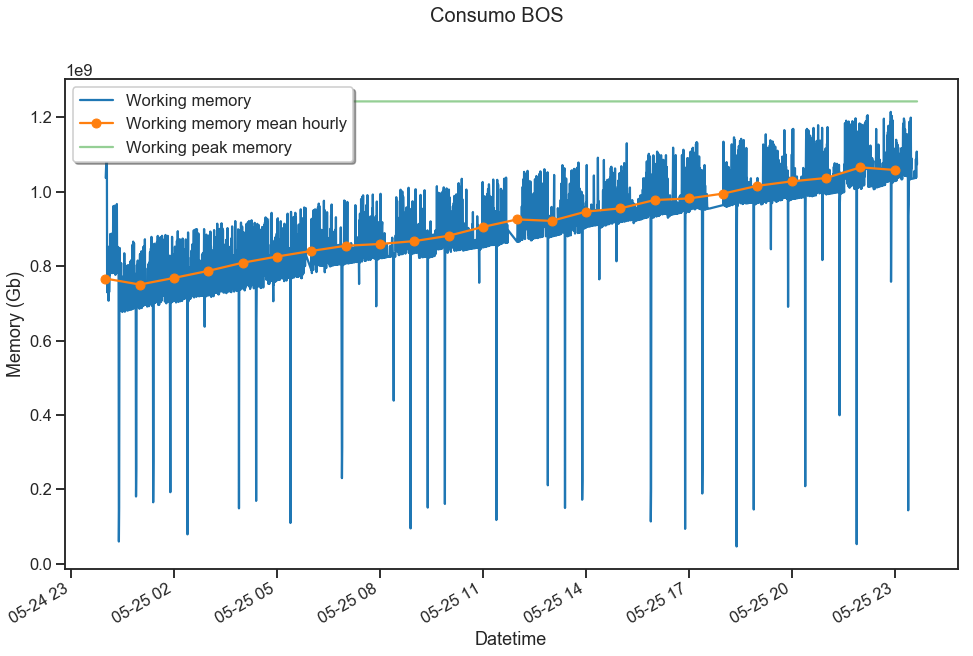

In [11]:
# gráfico consumo BOS
sns.set_style("ticks")
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Consumo BOS', fontsize=20)
df['working memory'].plot(ax=ax, alpha=1)
df['working memory'].resample('H').mean().plot(ax=ax, marker='o')
df['working peak memory'].plot(ax=ax, alpha=0.5)
ax.legend(['Working memory','Working memory mean hourly','Working peak memory'], 
          loc='upper left',
          shadow=True, 
          frameon=True)
plt.ylabel('Memory (Gb)')
plt.xlabel('Datetime');
plt.show()

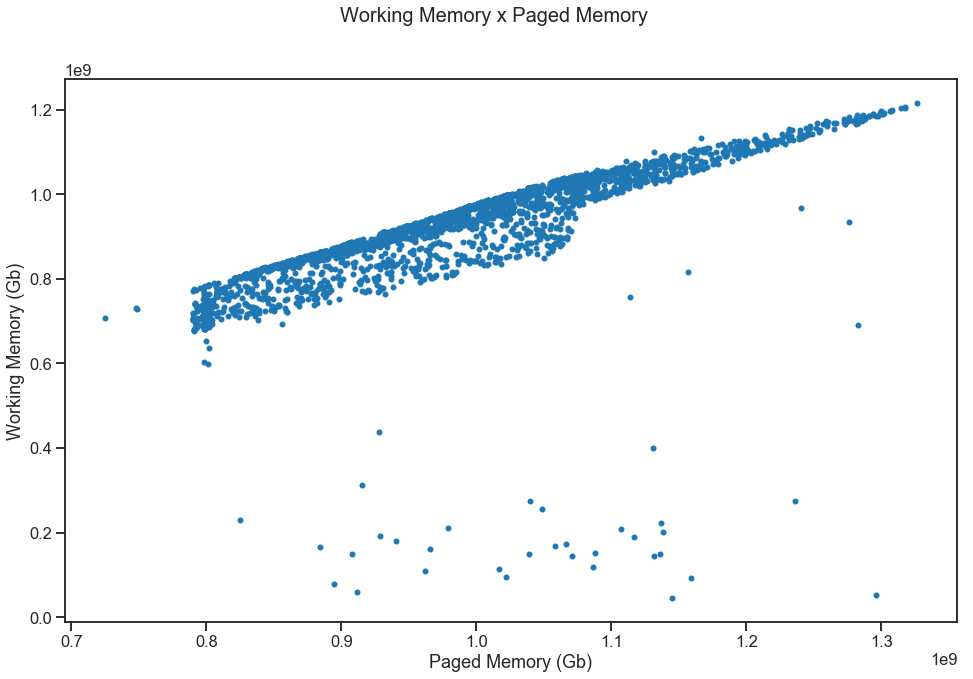

In [12]:
# gráfico working memory x paged memory 
sns.set_style("ticks")
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Working Memory x Paged Memory ', fontsize=20)
df.plot(ax=ax, kind='scatter', x='paged memory',y='working memory')
plt.ylabel('Working Memory (Gb)')
plt.xlabel('Paged Memory (Gb)')
plt.show()

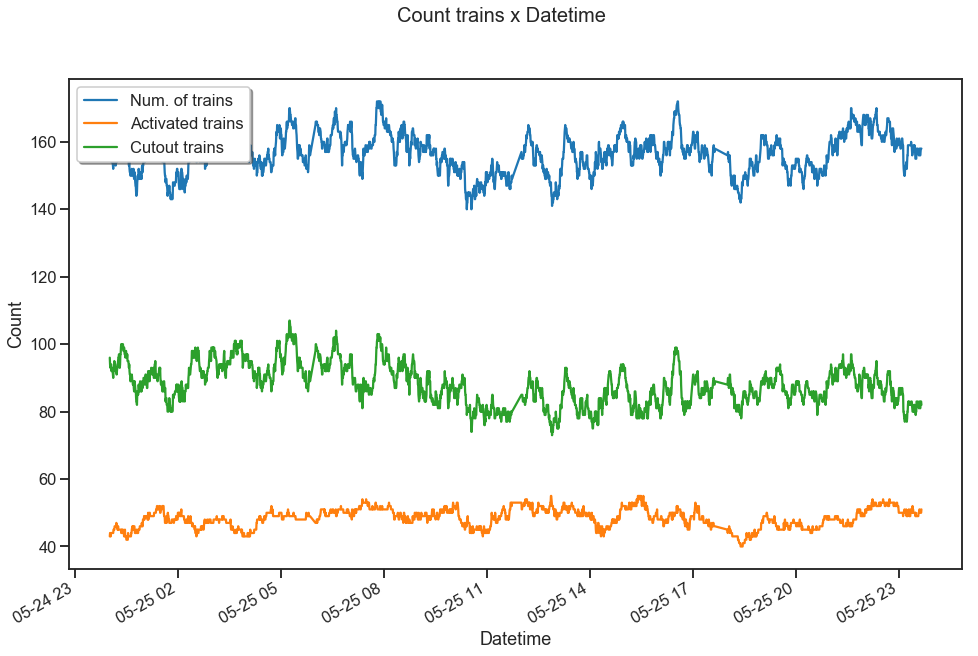

In [13]:
# gráfico memory used x number of trains
sns.set_style("ticks")
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(16, 10))
fig.suptitle('Count trains x Datetime', fontsize=20)
df['num of trains'].plot(ax=ax)
df['activated trains'].plot(ax=ax)
df['cutout trains'].plot(ax=ax)
#df['memory used'].plot(ax=ax)
ax.legend(['Num. of trains','Activated trains','Cutout trains'], 
          loc='upper left',
          shadow=True, 
          frameon=True)
plt.ylabel('Count')
plt.xlabel('Datetime')
plt.show()

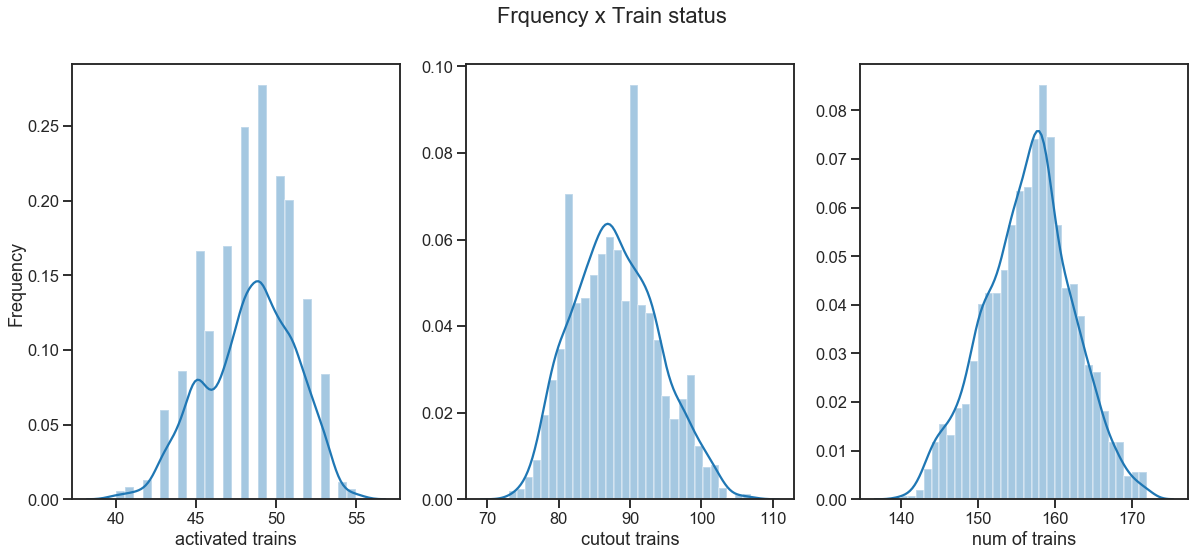

In [14]:
warnings.filterwarnings('ignore')
# gráfico working memory x paged memory 
sns.set_style("ticks")
sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(20, 8))
fig.suptitle('Frquency x Train status', fontsize=22)
sns.distplot(df['activated trains'], ax=ax[0])
sns.distplot(df['cutout trains'], ax=ax[1])
sns.distplot(df['num of trains'], ax=ax[2])
fig.text(0.08, 0.5, 'Frequency', va='center', rotation='vertical')
plt.show()